<a href="https://colab.research.google.com/github/Kevin-Sean-Chen/Neural-Dynamics/blob/master/PTA_dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.optim as optim

plt.rcParams.update({'font.size': 20})

## Fixed point and line attractor model

Use either connectivity to simulate attractor models with ReLU nonlinearity

### $\frac{dx}{dt} = -x + \sigma (Wx + b)$

With $\sigma=ReLU$ and $W_{ij}$ being the attractor network

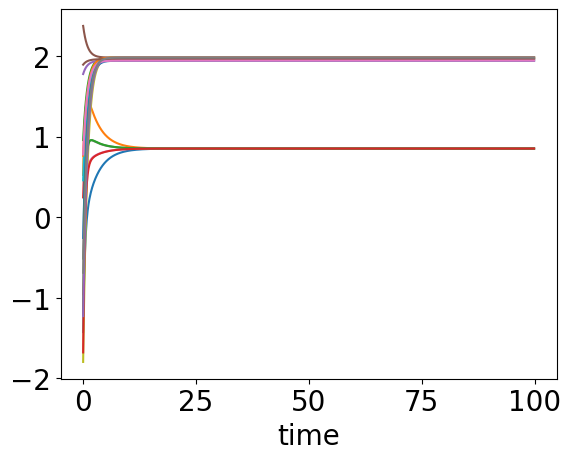

In [ ]:
### time vectors
dt = 0.1
T = 100
time = np.arange(0,T,dt)
lt = len(time)

### network setup
N = 6
# for two fixed-point attractor
W_fp = np.array([[-.35, -1,0,0,0,0 ],
                 [-1, -.35, 0,0,0,0],
                 [0,0,-0.01,0,0,0],
                 [0,0,0,-0.02, 0,0],
                 [0,0,0,0,-0.03,0],
                 [0,0,0,0,0,-0.01]])
# W_fp = np.array([[.35,-1,0,0,0,0],[-1,.35,0,0,0,0],[0,0,-.01,0,0,0],[0,0,0,-.02,0,0],[0,0,0,0,-.03,0],[0,0,0,0,.0,-0.01]])


# for line attractor
W_line = np.zeros((N,N))
np.fill_diagonal(W_line, np.array([0,0,-2,-2,-2,-2,]))
W_line[0,1] = -1
W_line[1,0] = -1
b = 2  # bias
tau = 10  # time scale

def NL(x):
    nl = np.maximum(0, x)  # ReLU nonlinearity
    return nl
### neural dynamics
reps = 3
for rr in range(reps):  # repeat trials with random inital coniditons
    W = 1*W_fp
    xt = np.zeros((N,lt))
    xt[:,0] = np.random.randn(N)*2
    for tt in range(lt-1):
        xt[:,tt+1] = xt[:,tt] + dt*(-xt[:,tt] + NL(W @ xt[:,tt] + b))  # Euler solve for ODE

    # plt.figure()
    plt.plot(time, xt.T);
    plt.xlabel('time');

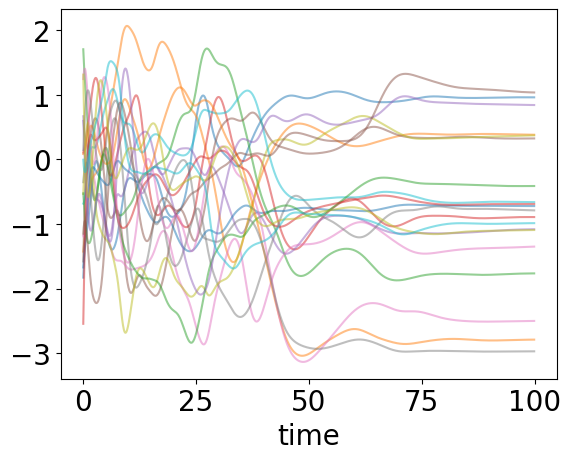

In [ ]:
### chaotic network
N = 200
tau = 1
pc = 0.1
g = 1.8
W_ch = np.random.randn(N,N)*g/np.sqrt(N*pc)  # chaotic neural network connectivity
M1 = np.random.rand(N,N)
M2 = np.zeros((N,N))  # spasity mask
M2[M1<pc] = 1
W_ch = W_ch*M2

### neural dynamics
def NL(x):
    nl = np.tanh(x)  # tanh nonlinearity
    return nl
W = 1*W_ch
xt = np.zeros((N,lt))
xt[:,0] = np.random.randn(N)*1
for tt in range(lt-1):
    xt[:,tt+1] = xt[:,tt] + dt/tau*(-xt[:,tt] + W @ NL(xt[:,tt]))

plt.figure()
plt.plot(time, xt[:20,:].T, alpha=0.5);
plt.xlabel('time');

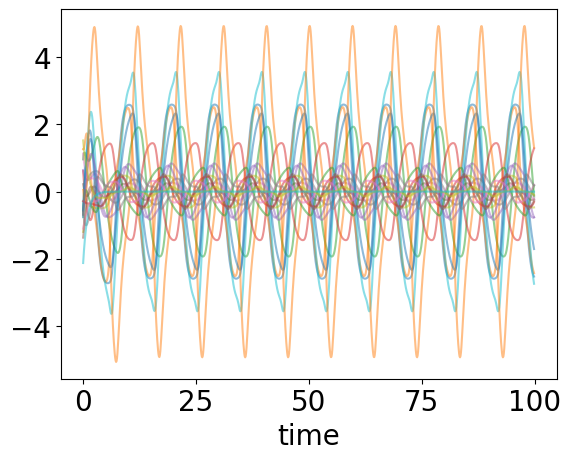

In [ ]:
### small limit-cycle network
# simply using a small random network often induces oscillations
N = 20
tau = 1
pc = 0.1
g = 1.8
W_lim = np.random.randn(N,N)*g/np.sqrt(N*pc)
M1 = np.random.rand(N,N)
M2 = np.zeros((N,N))
M2[M1<pc] = 1
W_lim = W_lim*M2

### neural dynamics
W = 1*W_lim
xt = np.zeros((N,lt))
xt[:,0] = np.random.randn(N)*1
for tt in range(lt-1):
    xt[:,tt+1] = xt[:,tt] + dt/tau*(-xt[:,tt] + W @ NL(xt[:,tt]))

plt.figure()
plt.plot(time, xt[:20,:].T, alpha=0.5);
plt.xlabel('time');

## Computing Lyapunov exponent

### $\lambda = lim \frac{1}{t}\log|Yp|$

with $Y = \frac{\delta x_t}{\delta x_{t0}}$

In [ ]:
### analysis functions for the Park et al. paper
def tanh_jacobian(t,W,b,tau,x_solved):
    #b is unused, but there for consistency with relu jac
    return (-np.eye(W.shape[0]) + np.multiply(W,1/np.cosh(x_solved[t,:])**2))/tau  # derivitive of tanh nonlinear function

def relu_jacobian(t,W,b,tau,x_solved):
    return (-np.eye(W.shape[0]) + np.multiply(W, np.where(np.dot(W,x_solved[t,:])+b>0,1,0)))/tau  # derivative of ReLU computed for Jacobian

def calculate_lyapunov_spectrum(act_fun_jac,W,b,tau,x_solved,delta_t,from_t_step=0):
    #Benettin 1980: Lyapunov Characteristic Exponents for smooth dynamical
    #Echmann and Ruelle 1985: Ergodic theory of chaos and strange attractors
    N = W.shape[0]
    Q_n = np.eye(N)
    lyap_spec = np.zeros(N)
    lyaps = []
    N_t = x_solved.shape[0]  # time x neuron trajectories
    for tt in range(from_t_step,N_t):
        M_n = np.eye(N) + act_fun_jac(tt, W, b, tau, x_solved)*delta_t
        Q_n, R_n = np.linalg.qr(np.dot(M_n, Q_n))  # discrete QR decomposition method
        lyap_spec += np.log(np.abs(np.diag(R_n)))/(N_t*delta_t)  # take the log of diagonal
        lyaps.append(lyap_spec)
    return lyap_spec, lyaps

In [ ]:
x_solved = xt.T
lyap_spec, lyaps = calculate_lyapunov_spectrum(tanh_jacobian, W_lim, b, tau, x_solved, dt, from_t_step=0)
# lyap_spec, lyaps = calculate_lyapunov_spectrum(tanh_jacobian, W_ch, b, tau, x_solved, dt, from_t_step=0)

Text(0, 0.5, 'Lyapunov')

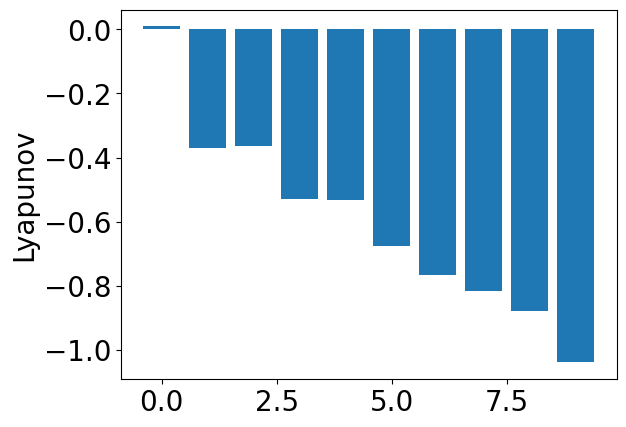

In [ ]:
plt.bar(np.arange(0,N//2), lyap_spec[:N//2])
plt.ylabel('Lyapunov')

In [ ]:
### structural stability analysis
W = W_line*1
# W = W_fp*1
# W = W_lim*1

N = W.shape[0]
reps = 10
s_noises = np.arange(0,10)*0.5/np.linalg.norm(W)
rs = np.zeros((reps, len(s_noises)))

def NL(x):
    nl = np.maximum(0,x)
    # nl = np.tanh(x)
    return nl
xt_temp = np.zeros((N,lt))
xt_temp[:,0] = np.random.randn(N)*2
for tt in range(lt-1):
    xt_temp[:,tt+1] = xt_temp[:,tt] + dt*(-xt_temp[:,tt] + NL(W @ xt_temp[:,tt] + b))

for rr in range(reps):
    for ss in range(len(s_noises)):
        s_noise = s_noises[ss]
        W_temp = W + np.random.randn(N,N)*s_noise  # perturbing the network connectivity with scaled noise

        xt = np.zeros((N,lt))
        xt[:,0] = xt_temp[:,0]*1
        for tt in range(lt-1):
            xt[:,tt+1] = xt[:,tt] + dt*(-xt[:,tt] + NL(W_temp @ xt[:,tt] + b))
        rs[rr,ss] = np.sqrt(np.sum((xt[:,-1] - xt_temp[:,-1])**2))/N   # compute the MSE from the final target in the unperturbed signal

(0.0, 2.0)

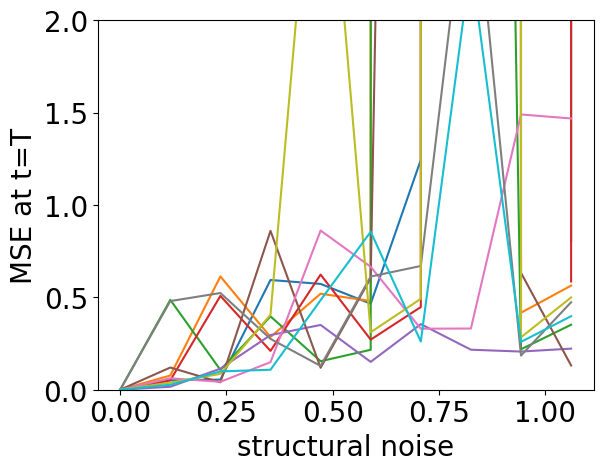

In [ ]:
plt.plot(s_noises, rs.T);
plt.xlabel('structural noise')
plt.ylabel('MSE at t=T')
plt.ylim([0,2])

Text(0, 0.5, 'Im')

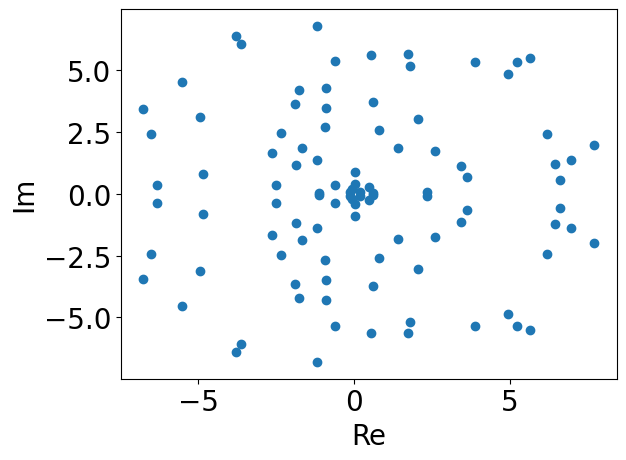

In [ ]:
n_blocks = 50
alphas = np.random.rand(n_blocks)*8
thetas = np.random.rand(n_blocks)*np.pi

matrix_size = n_blocks * 2
block_matrix = np.zeros((matrix_size, matrix_size))

# Fill the diagonal blocks with the 2x2 block
for i in range(n_blocks):
    block_matrix[i * 2:(i + 1) * 2, i * 2:(i + 1) * 2] = block(alphas[i], thetas[i])

uu,vv = np.linalg.eig(block_matrix)

plt.plot(np.real(uu), np.imag(uu),'o')
plt.xlabel('Re')
plt.ylabel('Im')

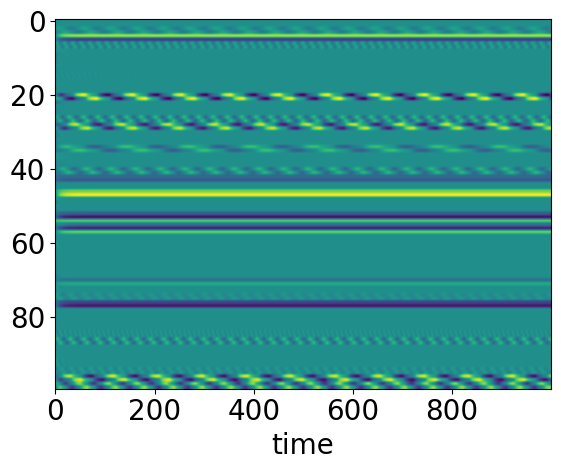

In [ ]:
W_pta = np.zeros((4,4))
def block(alpha, theta):
    B = alpha*np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta), np.cos(theta)]])
    return B
alpha1, alpha2 = 2.5, 5.5
theta1, theta2 = np.pi/5, np.pi/3
W_pta[:2,:2] = block(alpha1, theta1)
W_pta[-2:,-2:] = block(alpha2, theta2)

### neural dynamics
# W = 1*W_pta
W = 1*block_matrix
N = W.shape[0]
xt = np.zeros((N,lt))
xt[:,0] = np.random.randn(N)*1
for tt in range(lt-1):
    xt[:,tt+1] = xt[:,tt] + dt/tau*(-xt[:,tt] + W @ np.tanh(xt[:,tt]))

plt.figure()
# plt.plot(time, xt[:,:].T, alpha=0.5);
plt.imshow(xt, aspect='auto')
plt.xlabel('time');

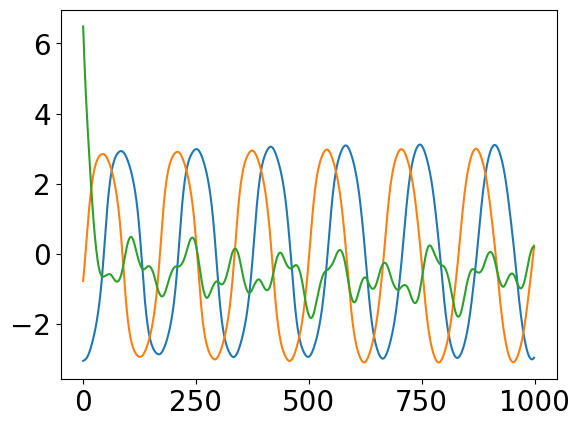

In [ ]:
uu,ss,vv = np.linalg.svd(np.cov(xt))
pcs = xt.T @ uu[:,:3]
plt.plot(pcs)

Text(0.5, 0.92, '3D Trajectory Plot')

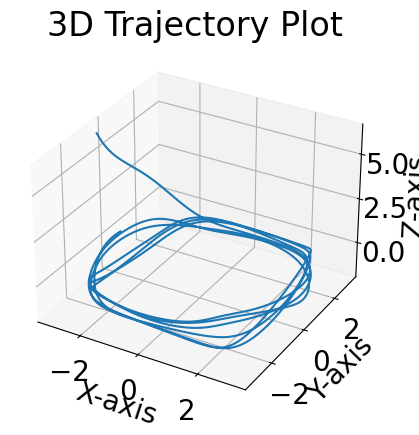

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # Import 3D plotting tools

# Example trajectory data (replace with your own data)
x = xt[0,:]
y = xt[1,:]
z = xt[3,:]
x,y,z = pcs[:,0], pcs[:,1], pcs[:,2]

# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the trajectory
ax.plot(x, y, z, label='Trajectory')

# Customize the plot (add labels, title, etc.)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('3D Trajectory Plot')


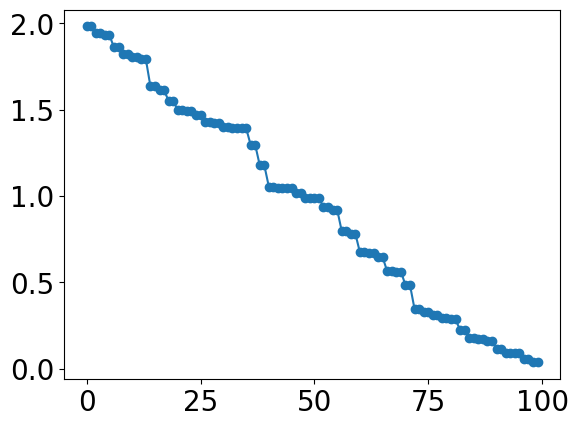

In [ ]:
uu,ss,vv = np.linalg.svd(block_matrix)
plt.plot(ss,'-o')

# Content for persistant toiroud attractor paper

### Lyapunov exponent computation
### Attractor examples
### Toiroidal dynamcis
### D-type noise demo